In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm #맷플롯립에서 colormap을 불러옴 : 데이터 값에 따라 색상으로 표현
#
from scipy.stats import qmc # upgrade scipy for LHS !pip install scipy --upgrade
#더 균일한 랜덤 분포를 얻는 qmc

In [2]:
tf.keras.backend.set_floatx("float64") #keras의 기본 데이터타입을 설정하는 함수 기본값: float32 -> float64(더 정확)

In [3]:
### generating data

# number of boundary and initial data points
# value `Nd` in the reference paper:
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points 
number_of_ic_points = 50
number_of_bc1_points = 25
number_of_bc2_points = 25
# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
# boundary and initial boundary
engine = qmc.LatinHypercube(d=1) #1차원 샘플을 만들어줄 엔진(인스턴스)생성

# temporal data points
t_d = engine.random(n=number_of_bc1_points + number_of_bc2_points)
temp = np.zeros([number_of_ic_points, 1]) # for IC ; t = 0
t_d = np.append(temp, t_d, axis=0)
# spatial data points
x_d = engine.random(n=number_of_ic_points)
x_d = 2 * (x_d - 0.5) #기본적으로 qmc는 0,1 사이의 난수를 생성 하므로 -1,1 범위로 난수 스케일링
temp1 = -1 * np.ones([number_of_bc1_points, 1]) # for BC1 ; x = -1
temp2 = +1 * np.ones([number_of_bc2_points, 1]) # for BC2 ; x = +1
x_d = np.append(x_d, temp1, axis=0)
x_d = np.append(x_d, temp2, axis=0)

#나중에 t_d, x_d를 합칠거니 이렇게 생성했고, 앞 50개는 초기조건, 뒤 50개는 경계조건 데이터

In [4]:
#output values for data points (boundary and initial)
y_d = np.zeros(x_d.shape)

# for initial condition: IC = -sin(pi*x)
y_d[ : number_of_ic_points] = -np.sin(np.pi * x_d[:number_of_ic_points])

# all boundary conditions are set to zero
y_d[number_of_ic_points : number_of_bc1_points + number_of_ic_points] = 0
y_d[number_of_bc1_points + number_of_ic_points : number_of_bc1_points + number_of_ic_points + number_of_bc2_points] = 0
     

# number of collocation points
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)
# set x values between -1. and +1.
data[:, 1] = 2*(data[:, 1]-0.5)

# change names
t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)
     

Text(0.5, 1.0, 'Data points (BCs & IC)')

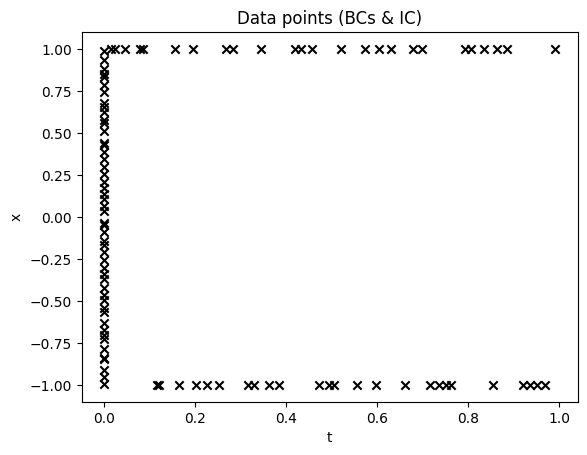

In [5]:
# view randomly sampled boundary and initial points
plt.scatter(t_d, x_d, marker="x", c="k")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (BCs & IC)")

In [6]:
# output values for data points (boundary and initial)
y_d = np.zeros(x_d.shape) #initializing the array y_d

# for initial condition: IC = -sin(pi*x)
y_d[ : number_of_ic_points] = -np.sin(np.pi * x_d[:number_of_ic_points]) #앞의 50개의 데이터인 초기조건 데이터들에 대한 함수값을 초기조건에 맞게설정

# all boundary conditions are set to zero
y_d[number_of_ic_points : number_of_bc1_points + number_of_ic_points] = 0 #50-75 까지 0으로 설정 (경계조건 1)
y_d[number_of_bc1_points + number_of_ic_points : number_of_bc1_points + number_of_ic_points + number_of_bc2_points] = 0 #75-100 까지 0으로 설정 (경계조건 2)

In [7]:
# number of collocation points
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)
# set x values between -1. and +1.
data[:, 1] = 2*(data[:, 1]-0.5) #x값들이 도메인 안에 들어가도록 스케일링

# change names #t,x데이터들 분리하기.
t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)

In [8]:
# convert all data and collocation points to tf.Tensor
x_d, t_d, y_d, x_c, t_c = map(tf.convert_to_tensor, [x_d, t_d, y_d, x_c, t_c])

In [9]:
### model design
#
neuron_per_layer = 20
# activation function for all hidden layers
actfn = "tanh"

# input layer
input_layer = tf.keras.layers.Input(shape=(2,)) #[a,b]형태의 입력값이 들어간다 즉 두개의 feature을 가지는 데이터를 입력시키는것.

# hidden layer
# also a for loop could be used instead of multiple lines of code
hidden0 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)
hidden1 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden0)
hidden2 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden1)
hidden3 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden2)
hidden4 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden3)
hidden5 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden4)
hidden6 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden5)
hidden7 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden6)
hidden8 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden7)

# output layer
output_layer = tf.keras.layers.Dense(1, activation=None)(hidden8)

model = tf.keras.Model(input_layer, output_layer) #입력층과 출력층만 지정하면 되는이유: tf는 자동으로 레이어 간 연결을 추적하기 때문

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,441 (26.88 KB)

 Trainable params: 3,441 (26.88 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# u(t, x) just makes working with model easier and the whole code looks more
# like its mathematical backend
@tf.function
def u(t, x):
    # model input shape is (2,) and `u` recieves 2 arguments with shape (1,)
    # to be able to feed those 2 args (t, x) to the model, a shape (2,) matrix
    # is build by simply concatenation of (t, x)
    u = model(tf.concat([t, x], axis=1)) # note the axis ; `column`
    return u

#즉 함숫값을 반환하는 함수

In [11]:
# the physics informed loss function
# IMPORTANT: this loss function is used for collocation points
@tf.function
def f(t, x):    
    u0 = u(t, x)
    u_t = tf.gradients(u0, t)[0]
    u_x = tf.gradients(u0, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    F = u_t + u0*u_x - (0.01/np.pi)*u_xx
    return tf.reduce_mean(tf.square(F)) #MSE_f 반환  
#텐서플로우 1에서 주로 사용하는 gradient 메소드를 이용해서 미분 구현

In [12]:
# MSE loss function
# IMPORTANT: this loss function is used for data points
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))  #MSE_y 반환

In [13]:
import time #경과시간 측정을 위한 모듈 호출

In [14]:
"""
BENCHMARK on Google Colab GPU

learning_rate = 5e-4
epochs = 2000
training time ~ 85.60 s
final loss = 0.006
"""

epochs = 2000 #epochs : 반복횟수
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4) 
start = time.time()

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction!
        y_ = u(t_d, x_d)
        # physics-informed loss for collocation points
        L1 = f(t_c, x_c)
        # MSE loss for data points
        L2 = mse(y_d, y_)
        loss = L1 + L2
    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list.append(loss)
    # log every 10 epochs
    if (not epoch%10) or (epoch == epochs-1):
        print(f"{epoch:4} {loss.numpy():.3f}")
    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))

end = time.time()
print(f"{end - start:.3} (s)")

   0 0.355
  10 0.185
  20 0.187
  30 0.174
  40 0.169
  50 0.159
  60 0.148
  70 0.139
  80 0.133
  90 0.128
 100 0.124
 110 0.121
 120 0.118
 130 0.115
 140 0.112
 150 0.109
 160 0.107
 170 0.104
 180 0.101
 190 0.098
 200 0.096
 210 0.094
 220 0.092
 230 0.090
 240 0.089
 250 0.087
 260 0.085
 270 0.084
 280 0.082
 290 0.081
 300 0.080
 310 0.078
 320 0.077
 330 0.076
 340 0.075
 350 0.074
 360 0.073
 370 0.072
 380 0.070
 390 0.069
 400 0.068
 410 0.067
 420 0.066
 430 0.065
 440 0.064
 450 0.064
 460 0.063
 470 0.062
 480 0.062
 490 0.061
 500 0.061
 510 0.060
 520 0.060
 530 0.060
 540 0.059
 550 0.059
 560 0.059
 570 0.058
 580 0.058
 590 0.058
 600 0.057
 610 0.057
 620 0.056
 630 0.056
 640 0.056
 650 0.056
 660 0.055
 670 0.055
 680 0.054
 690 0.055
 700 0.054
 710 0.053
 720 0.053
 730 0.053
 740 0.052
 750 0.052
 760 0.053
 770 0.052
 780 0.051
 790 0.051
 800 0.051
 810 0.050
 820 0.050
 830 0.050
 840 0.050
 850 0.049
 860 0.048
 870 0.048
 880 0.048
 890 0.048
 900 0.047

Text(0.5, 0, 'epoch')

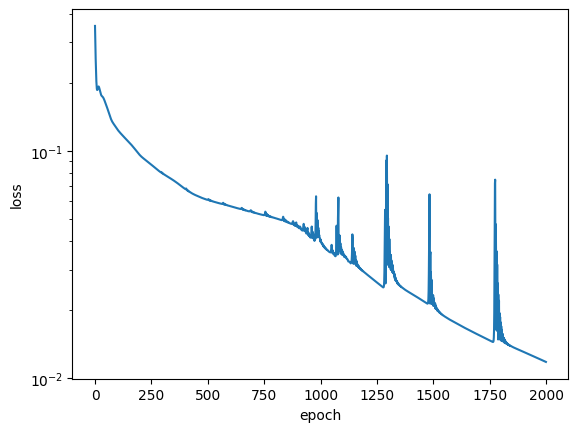

In [15]:
plt.semilogy(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

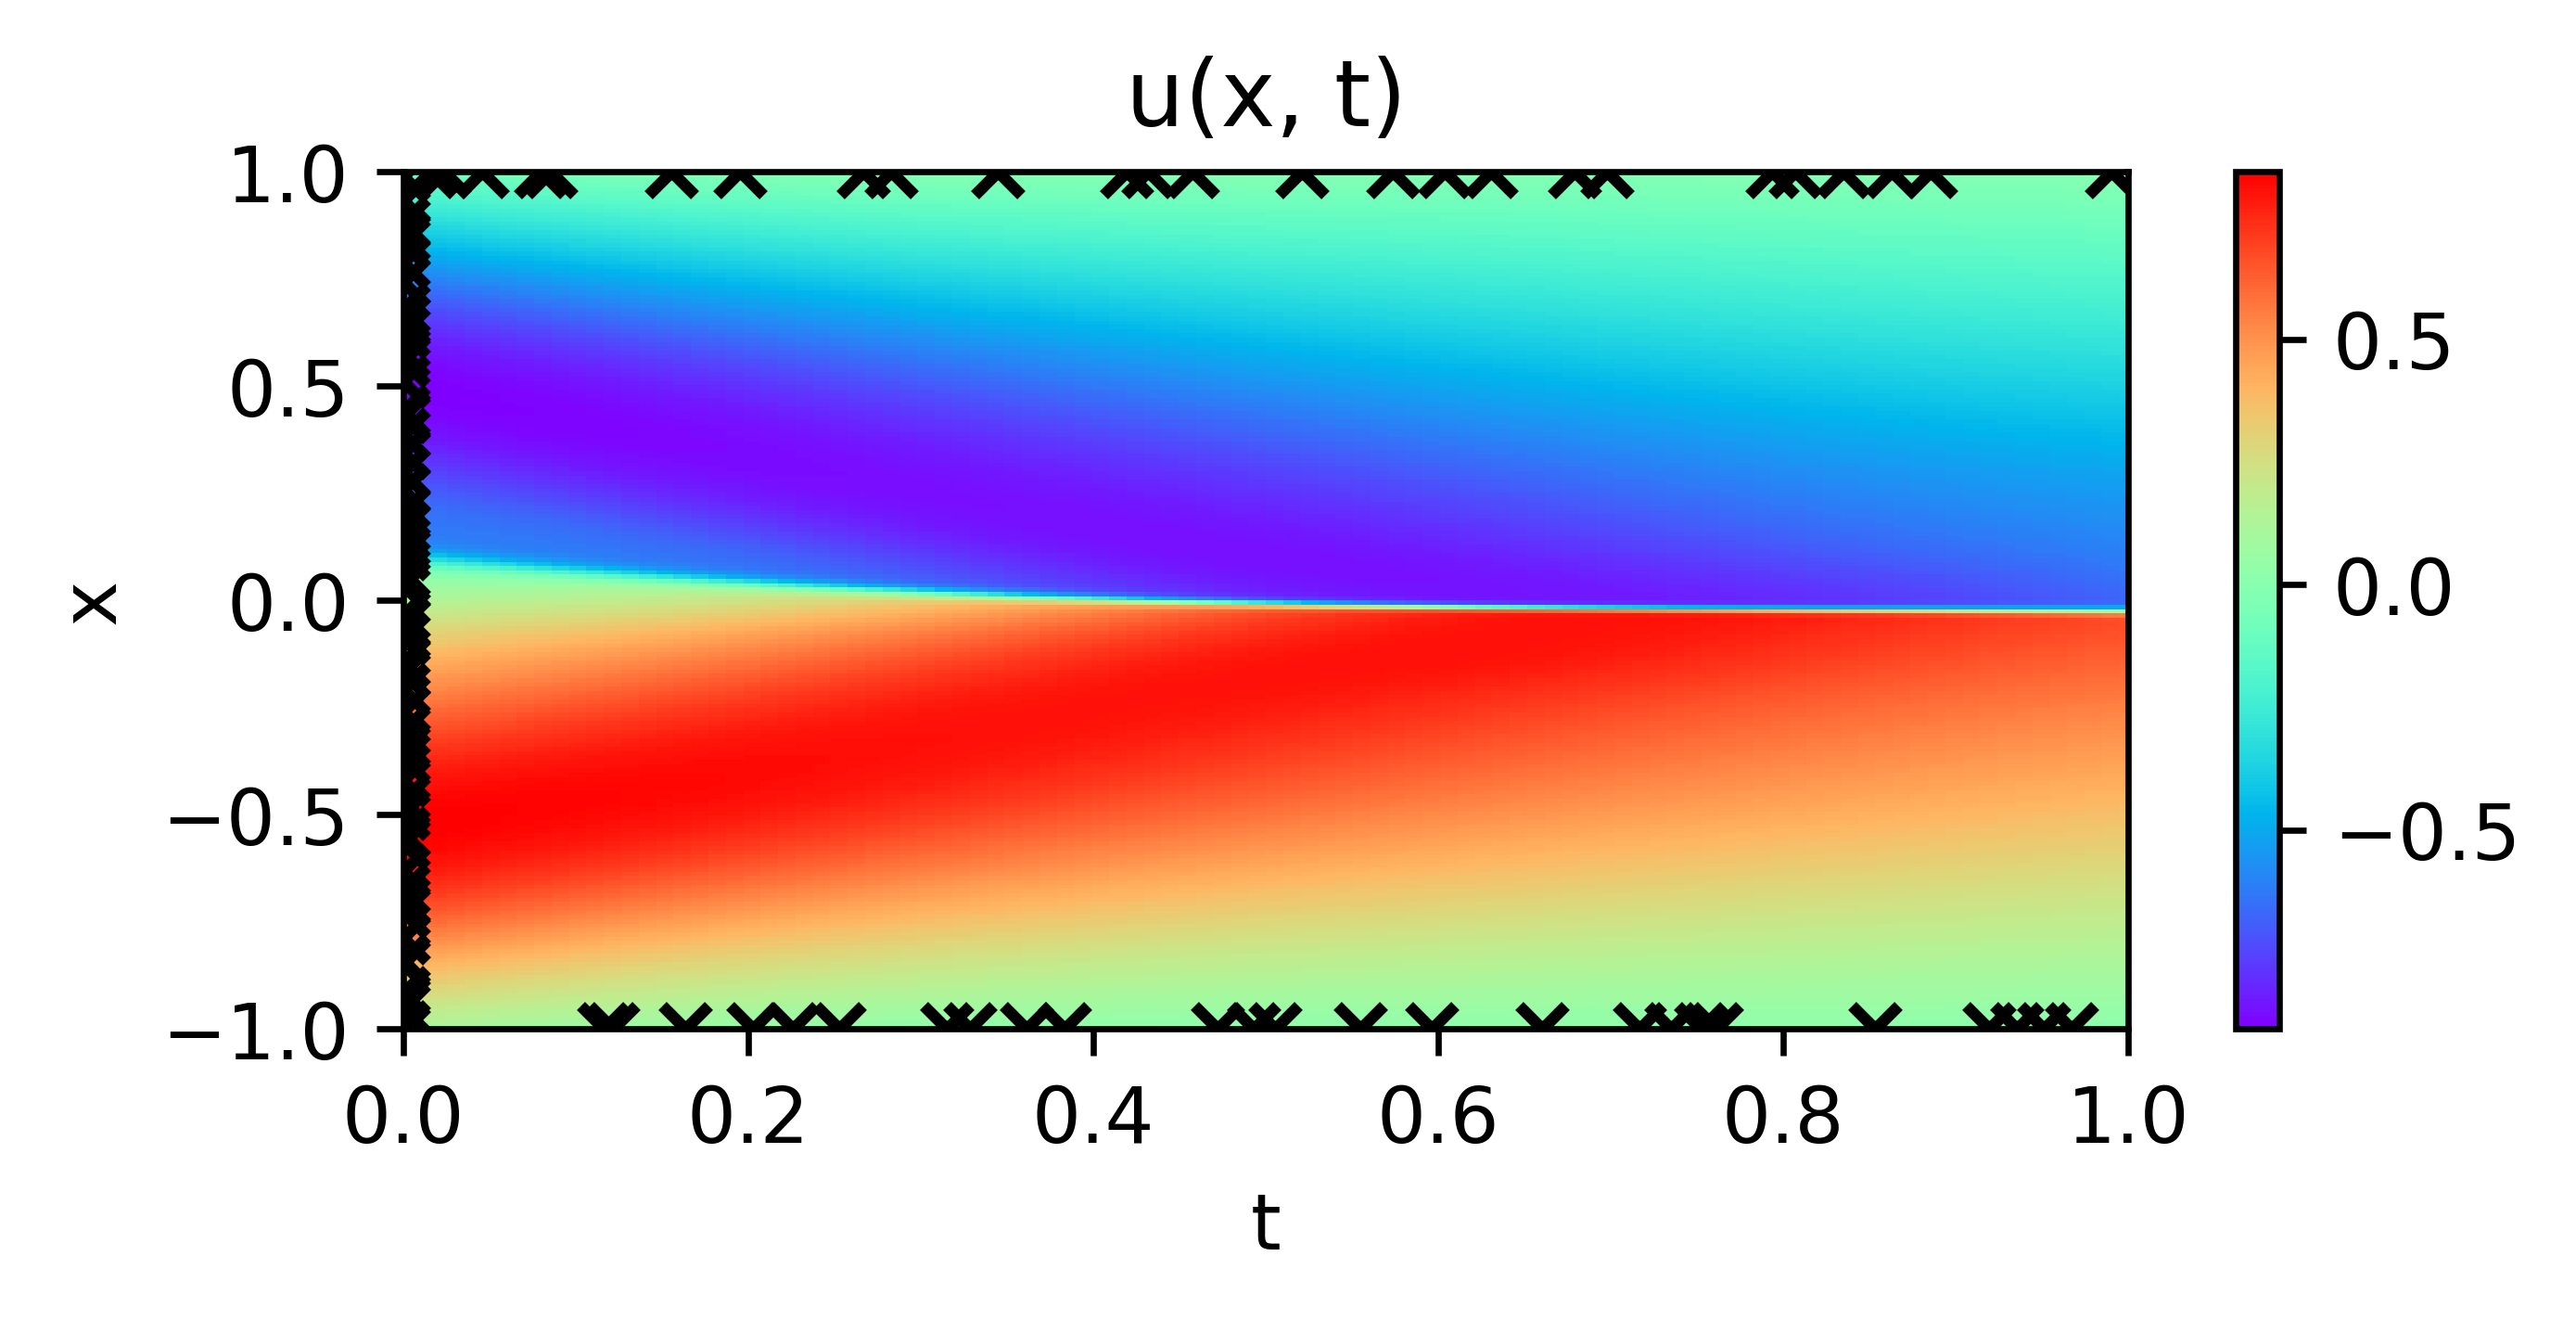

In [16]:
### plot
# another code is also available for ploting
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)
X.shape, T.shape
plt.figure(figsize=(5, 2), dpi=600)
S = u(T, X)
S = S.numpy().reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()

In [17]:
# save and copy model to drive

model.save("burgers0.h5")
! cp burgers0.h5 drive/MyDrive

'cp'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
